In [61]:
# Libraries
import os
import random
from datetime import datetime, date, timedelta
from typing import Dict, List, Tuple, Union
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import seaborn as sns
import requests
import zipfile
import io

In [51]:
#utils

def find_files(
    filename: str  = None, 
    search_path:str = None,
    print_bool: bool = False
    )-> None:
    """
    Find any file and returns the filename and its path
    Args:
    filename = filename to be searched for 
    search_path = directory of the Searching path
    """
    dir_path = None
    for root, dir, files in os.walk(search_path):
        if filename in files:
            dir_path = Path(os.path.join(root, filename)).parent.as_posix()
    if dir_path not in sys.path:
        sys.path.append(dir_path)
    file_path = Path(os.path.join(dir_path, filename)).as_posix()
    if print_bool:
        print("\nPath to your file is :\n", file_path)
        print("\nDirectory of that file is:\n", dir_path)
        return dir_path, file_path
    else:
        return dir_path, file_path

def create_dir(
    working_dir:str = None,
    dir_name:str = None
    )->None:
    """
    A function to create a directory and attach that 
    to the working directory
    Args:
    working_dir = Wokrking directory
    dir_name = Name of the directory needed to be created
    """
    dir = os.path.join(Path(working_dir).as_posix(), dir_name)
    if not os.path.exists(dir):
        os.makedirs(dir, exist_ok = True)
    return dir

def download_zip_url(
    zip_file_url: str = None,
    path_to_save:str = None
    )->None:
    """
    A function to download a zip file from the url
    and save it in a specified folder
    Args:
    zip_file_url = url of the zip file
    path_to_save = A path of the folder to which
    the zip files are going to be extracted to
    """
    #Downloading and extracting
    print("\nDownloading the zip files...........\n")
    with requests.get(zip_file_url, stream = True) as r:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        print("\nDownload complete.......................\n")
        print("\nBegin Extracting the files in zip..........\n")
        z.extractall(path = path_to_save)
        print("\nExtraction complete............\n")
    

In [ ]:
class dataops():
    def __init__(
        self,
        downloads_path:Path[Union, str],
        metafilename:str,
        netcdffilename:str)->None:
        """
        Args:
        downloads_path = Set the path where the downloaded meta and netcdf files are
        metafilename = input the metadata file name inclusing extension(.csv)
        netcdffilename = as suggested above including the extension(.netcdf)
        """        
        #Setting the path and loading the datasets
        # downlods_path = Path(r"c:\\Users\\vardh\\OneDrive - University of Leicester\\OCF\\Git_repos\\downloads")
        self.downloads_path = downloads_path
        self.metafilename = metafilename
        self.netcdffilename = netcdffilename
        self.uk_pv_meta_path = Path(os.path.join(self.downloads_path, self.metafilename))
        self.uk_pv_netcdf_path = Path(os.path.join(self.downloads_path, self.netcdffilename)) 
    
    def load_data(self)->None:
        """
        Reading the data into variables
        """
        dataops.metadata_df = pd.read_csv(self.uk_pv_meta_path.as_posix())
        dataops.pv_power = xr.open_dataset(self.uk_pv_netcdf_path.as_posix(), engine="h5netcdf")

    def dates_list(self)->None:
        """
        Converts dates as coorniates from xarray dataset to a list
        """
        self.dates_lst = dataops.pv_power.coords["datetime"].values
        self.dates_lst = [pd.to_datetime(str(i))for i in self.dates_lst]
        self.dates_lst = [i.strftime('%Y-%m-%d') for i in self.dates_lst]
        dataops.dates_lst = list(set(self.dates_lst))

if __name__ == "__main__":
    downloads_path = r"c:\\Users\\vardh\\OneDrive - University of Leicester\\OCF\\Git_repos\\downloads\\huggingface_uk_pv"
    metafilename = "uk_pv_metadata.csv"
    netcdffilename = "uk_pv_netcdf.netcdf"
    dops = dataops(
        downloads_path = downloads_path,
        metafilename = metafilename,
        netcdffilename = netcdffilename        
    )
    dops.load_data()
    dops.dates_list()




Download complete.......................


Begin Extracting the files in zip..........


Extraction complete............


Path to your file is :
 c:/Users/vardh/OneDrive - University of Leicester/OCF/Git_repos/downloads/UK_shp/infuse_ctry_2011.shp

Directory of that file is:
 c:/Users/vardh/OneDrive - University of Leicester/OCF/Git_repos/downloads/UK_shp

Data type of the shape file is
 <class 'geopandas.geodataframe.GeoDataFrame'>

 Spatial extent of the shape file
 [-6.91253961e+01  5.33360200e+03  6.55989000e+05  1.22030150e+06]

CRS of the shape file is
 epsg:27700

New CRS for the shape file is
 epsg:27700


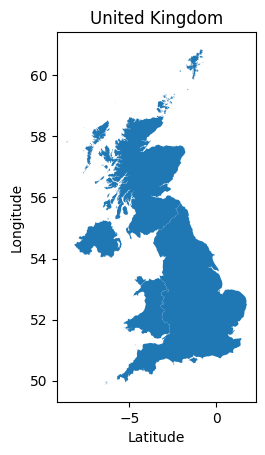

In [54]:
class plot_shp:
    def __init__(self)-> None:
        """"""
        pass
 
    @staticmethod
    def gpd_shp(
        shp_path:str
        ):
        """
        A function that takes a shape file and
        converts its epsg to 4326 and returns
        new shapefile laoded in a geopandas variable
        """
        shp_df = gpd.read_file(shp_path)
        df_type = type(shp_df)
        print("\nData type of the shape file is\n", df_type)
        sp_extent = shp_df.total_bounds
        print("\n Spatial extent of the shape file\n", sp_extent)
        shp_crs = shp_df.crs
        print("\nCRS of the shape file is\n", shp_crs)
        plot_shp.shp_df = shp_df.to_crs(epsg = 4326)
        print("\nNew CRS for the shape file is\n", shp_df.crs)
        return plot_shp.shp_df
    
    def shp_plot(self)->None:
    #Plotting the data
      ax = plot_shp.shp_df.plot()
      ax.set_title("United Kingdom")
      ax.set_xlabel('Latitude')
      ax.set_ylabel('Longitude')        


if __name__ == "__main__":
    # filename = "infuse_uk_2011.shp"
    # search_path = r"c:\\Users\\vardh\\OneDrive - University of Leicester\\OCF\\Git_repos\\downloads\\"
    filename = "infuse_ctry_2011.shp"
    zip_file_url = "https://borders.ukdataservice.ac.uk/ukborders/easy_download/prebuilt/shape/infuse_ctry_2011.zip"
    working_dir = r"c:\\Users\\vardh\\OneDrive - University of Leicester\\OCF\\Git_repos\\downloads\\"

    #Create a directory to store the shape file
    path_to_save = create_dir(
        working_dir = working_dir,
        dir_name = "UK_shp"
    )
    #Downloading and extracting shapefile through url    
    download_zip_url(
        zip_file_url = zip_file_url,
        path_to_save = path_to_save
    )
    #finding the shape file
    _, shp_path = find_files(
        filename = filename,
        search_path = path_to_save,
        print_bool = True
    )

    #Plotting the shapefile
    ps = plot_shp()
    ps.gpd_shp(
        shp_path = shp_path        
    )
    ps.shp_plot()


Path to your file is :
 c:/Users/vardh/OneDrive - University of Leicester/OCF/Git_repos/downloads/UK_shp/infuse_ctry_2011.shp

Directory of that file is:
 c:/Users/vardh/OneDrive - University of Leicester/OCF/Git_repos/downloads/UK_shp


c:\Users\vardh\Anaconda3\envs\pv_data_eda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


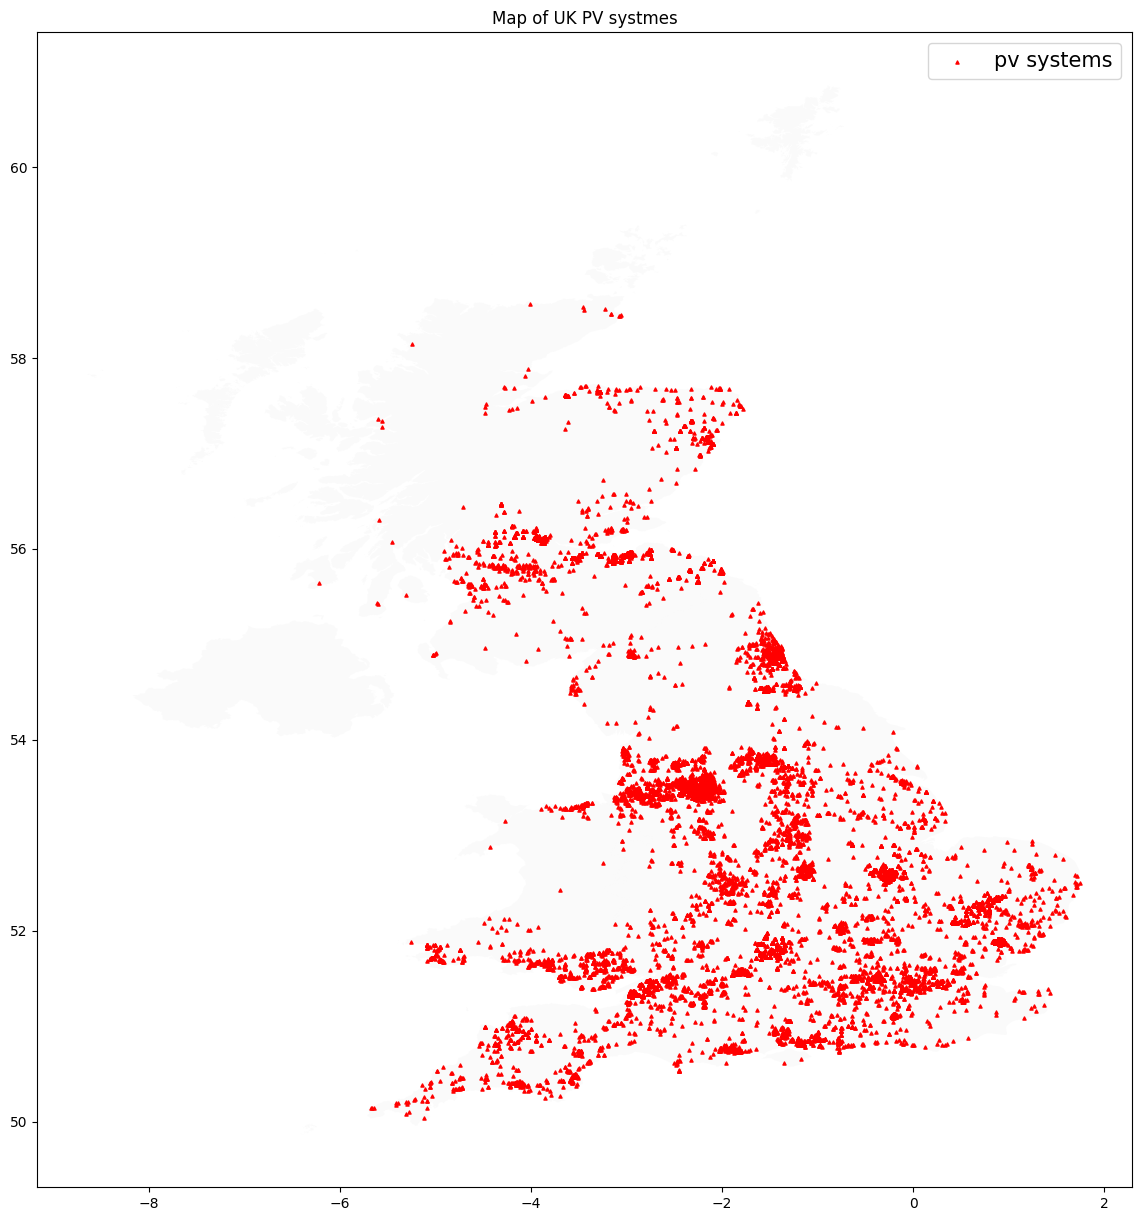

In [95]:
class uk_pv_coords:
    def __init__(self)-> None:
        """"""
        pass
    
    @staticmethod
    def uk_pv_plot(
        latitude:List,
        longitude:List,
        shpfile_path:Union[Path, str]):
        
        crs = {'init':'EPSG:4326'}
        #Reading the shape file and plotting
        shpfile = gpd.read_file(shpfile_path, bbox=None, mask=None, rows=None)

        #Creating a Point file dictionary of all the coordinates 
        geometry = [Point(xy) for xy in zip(longitude,latitude)]

        #Creating a GeoPnadas data frame
        geo_df = gpd.GeoDataFrame(
            dataops.metadata_df,
            crs = crs,
            geometry = geometry)
        geo_df = geo_df.set_crs('epsg:4326', allow_override = True)
        
        #plotting
        fig, ax = plt.subplots(figsize = (15,15))
        shpfile.to_crs(epsg = 4326).plot(ax = ax, alpha = 0.1, color = "grey", aspect = 1)        
        geo_df.plot(ax = ax, markersize = 5, color = "red", marker = "^", label = "pv systems", aspect = 1)        
        plt.legend(prop = {'size' : 15})
        ax.set_title("Map of UK PV systmes")

        

if __name__ == "__main__":
    #finding the shape file   
    filename = "infuse_ctry_2011.shp"
    zip_file_url = "https://borders.ukdataservice.ac.uk/ukborders/easy_download/prebuilt/shape/infuse_ctry_2011.zip"

    _, shpfile_path = find_files(
        filename = filename,
        search_path = path_to_save,
        print_bool = True)     
    latitude = dataops.metadata_df["latitude_rounded"].to_list()
    longitude = dataops.metadata_df["longitude_rounded"].to_list()

    upc = uk_pv_coords()
    upc.uk_pv_plot(
        latitude = latitude,
        longitude = longitude,
        shpfile_path = shpfile_path
    )

In [ ]:
class xr_df:
    def __init__(
        self,
        date_oi:str,
        ssid:str):
        self.date_oi = date_oi
        self.ssid = ssid

    @staticmethod                
    def xr_to_df(
        date_oi:str,
        ssid:str):
        """
        converts xarray dataset into a pandas dataframe, and its values for a single day
        Args:
        date_oi = Date of Interest
        ssid = ID of the PV system
        """
        # self.date_oi = "2021-10-24"     
        date_1 = datetime.strptime(date_oi, '%Y-%m-%d')
        next_day = date_1+timedelta(days=1)
        on_pv_system = dataops.pv_power[ssid].to_dataframe()
        on_pv_system = on_pv_system[(on_pv_system.index < next_day)&(on_pv_system.index > date_1)]
        xr_df.on_pv_system = on_pv_system
        return on_pv_system

    def display(
        self)->None:
        """
        Plot the PV output of the day that is randomly selected with SSID and a date
        """
        fig = plt.figure()
        plt.plot(xr_df.on_pv_system)
        fig.suptitle("One-day PV output time-series", fontsize = 10)
        plt.ylabel('Power output KWh', fontsize = 10)
        plt.xlabel(self.date_oi, fontsize = 10)
        plt.xticks([])

if __name__=="__main__":
    ssid = random.choice(list(dataops.pv_power))
    # ssid = "26797"
    date_oi = random.choice(list(dataops.dates_lst))
    # date_oi = "2018-06-21"
    print("Randomly selected date is", date_oi) 
    print("Randomly selected SSID is ", ssid)    
    xrdf = xr_df(
        date_oi = date_oi,
        ssid = ssid)
    xrdf.xr_to_df(
        date_oi = date_oi,
        ssid = ssid        
    )
    xrdf.display()

In [4]:
class no_pv_output:
    def __init__(
        self,
        ssid_list:List,
        dates_list:List
    )->None:
        self.ssid_list = ssid_list
        self.dates_list = dates_list
    
    @staticmethod
    def no_pv_df(
        ssid_list:List,
        dates_list:List
    ):
        """
        This function gives a pandas dataframe that stores 
        all the SSID with corresponding dates with no PV output
        Args:
        ssid_list = List of the ssid's of the PV systems
        dates_list = List of the dates that are of interest
        """
        no_pv_df = pd.DataFrame()
        for i in ssid_list:
            for j in dates_list:
                df = xr_df.xr_to_df(date_oi=j,ssid=i)
                df_values = df.values
                torf = np.isnan(df_values).all()
                if torf == False:
                    continue
                temp = pd.DataFrame(
                    {
                        'ssid': i,
                        'date':j
                    }, index = [0]
                )
                no_pv_df = pd.concat([no_pv_df, temp])
        return no_pv_df

if __name__ == "__main__":
    # ssid_list = list(dataops.pv_power)
    ssid_list = ["26797"]
    # dates_list = dataops.dates_lst
    dates_list = ["2020-12-01"]
    npo = no_pv_output(
        ssid_list = ssid_list,
        dates_list = dates_list        
    )
    npo.no_pv_df(
        ssid_list = ssid_list,
        dates_list = dates_list
    )

In [ ]:
#######
#IGNORE
#######

class no_pv_output():
    def __init__(self)->None:
        """"""
        pass
    @staticmethod
    def no_pv_dict():

        ssid_list = list(dataops.pv_power)
        ssid_list = ["10003"]
        no_pv_dict = {}
        for i in ssid_list:
            no_pv_dict[i] = None
        for key in no_pv_dict:
            ssid_pv_df = dataops.pv_power[key].to_dataframe()
            for j in range(len(xr_df.dates_lst)):
                no_pv_dates = []
                date_1 = datetime.strptime(xr_df.dates_lst[j], '%Y-%m-%d')
                next_day = date_1+timedelta(days=1)
                on_pv_system = ssid_pv_df[
                    (ssid_pv_df.index < next_day)
                    &
                    (ssid_pv_df.index > date_1)
                    ]                                
                torf = np.isnan(on_pv_system.values).all()
                # print(torf)
                if torf == True:
                    # print(date_1,"has no PV output on this system with ID", ssid_list[i])
                    no_pv_dates.append(xr_df.dates_lst[j])
                    pass
                print(no_pv_dates)


if __name__ == "__main__":
    npo = no_pv_output()
    npo.pv_output()
    
class check_na():
    def __init__(self):
        """"""
        pass
    def iter_xr(self)-> None:
        # self.true_false = []
        # ssid_lst = list(dataops.pv_power)
        # for i in ssid_lst:
        #     torf = np.isnan(dataops.pv_power[i].values).all()
        #     self.true_false.append(torf)
        # print(self.true_false)
        ssid_list = list(dataops.pv_power)
        print(type(ssid_list))
        self.dates_lst = dataops.pv_power.coords["datetime"].values
        self.dates_lst = [pd.to_datetime(str(i))for i in self.dates_lst]
        self.dates_lst = [i.strftime('%Y-%m-%d') for i in self.dates_lst]
        print(type(self.dates_lst))

if __name__ == "__main__":
    ckna = check_na()
    ckna.iter_xr()